In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

Generamos las observaciones

In [17]:
n = 5000
seed = 7672

# Elegimos la semilla 
np.random.seed(seed)

# Generamos los datos
edad = np.concatenate([np.random.normal(20, 2.5, 2500), np.random.normal(25, 3, 2500)])
exper = np.concatenate([np.random.normal(1.76, 0.5, 2500), np.random.normal(2.3, 0.75, 2500)])

# Centramos con respecto a la media
edad_c = edad - edad.mean()
exper_c = exper - exper.mean()

# Sacamos otras variables
edad_c2 = edad_c * edad_c
exper_c2 = exper_c * exper_c
edadexper = edad_c * exper_c

# Más variables
epsilon = np.random.normal(0, 0.5, n)
trat = np.concatenate([np.ones(2500), np.zeros(2500)])

# Resultados potenciales
y0 = 15000 + 10.25*edad_c + 10.5*edad_c2 + 1000*exper_c - 10.5*exper_c2 + 500*edadexper + epsilon
y1 = y0 + 2500 + 100*edad_c + 1000*exper_c

Verdadero ATE

In [18]:
ate = np.mean(y1) - np.mean(y0)
print(f'Verdadero ATE: {ate}')

Verdadero ATE: 2500.0


Verdadero ATT

In [19]:
att = np.mean((y1 - y0)[trat == 1])

print(f'Verdadero ATT: {att}')

Verdadero ATT: 1963.574062557549


_________________________________________

Ahora cambie la semilla (utilice como valor los ´ultimos tres n´umeros de su registro) y realice
1000 simulaciones con la misma especificaci´on pero en lugar de reportar para cada simulaci´on
el verdadero efecto promedio del programa (ATE) est´ımelo a partir de un modelo de regresi´on
con las siguientes especificaciones:

a) Efecto tratamiento homog´eneo y regresi´on sin t´erminos cuadr´aticos
y = β0 + β1 tratamiento + β2 Edadc + β3 Experienciac + ε 

In [42]:
n = 5000
seed1 = 263 # Cambiamos la semilla

simulaciones = 1000

ate_resultados_a = []
ate_resultados_b = []

# Elegimos la semilla 
np.random.seed(seed1)

for i in range(simulaciones):

    # Generamos los datos
    edad_sim = np.concatenate([np.random.normal(20, 2.5, int(n/2)), np.random.normal(25, 3, int(n/2))])
    exper_sim = np.concatenate([np.random.normal(1.76, 0.5, int(n/2)), np.random.normal(2.3, 0.75, int(n/2))])

    # Centramos con respecto a la media
    edad_sim_c = edad - edad.mean()
    exper_sim_c = exper - exper.mean()

    # Sacamos otras variables
    edad_sim_c2 = edad_sim_c * edad_sim_c
    exper_sim_c2 = exper_sim_c * exper_sim_c
    edadexper_sim = edad_sim_c * exper_sim_c

    # Más variables
    epsilon_sim = np.random.normal(0, 0.5, n)
    trat_sim = np.concatenate([np.zeros(int(n/2)), np.ones(int(n/2))])

    # Resultados potenciales
    y0_sim = 15000 + 10.25*edad_sim_c + 10.5*edad_sim_c2 + 1000*exper_sim_c - 10.5*exper_sim_c2 + 500*edadexper_sim + epsilon_sim
    y1_sim = y0_sim + 2500 + 100*edad_sim_c + 1000*exper_sim_c

#############################################################################################################
   
    # Creaamos un DataFrame para la simulación actual
    modelo_a = pd.DataFrame({'y_a': np.where(trat_sim == 1, y1_sim, y0_sim), 'trat': trat_sim, 'edad_sim_c': edad_sim_c, 'exper_sim_c': exper_sim_c})
    modelo_b = pd.DataFrame({'y_b': np.where(trat_sim == 1, y1_sim, y0_sim), 'trat': trat_sim, 'edad_sim_c': edad_sim_c, 'edad_sim_c2': edad_sim_c2, 'exper_sim_c': exper_sim_c, 'exper_sim_c2': exper_sim_c2, 'edadexper_sim': edadexper_sim})
    
    # Estimamos el ATE a través de un modelo de regresión para a)
    Xa = modelo_a[['trat', 'edad_sim_c', 'exper_sim_c']]
    Xa = sm.add_constant(Xa)  # Agregamos la constante
    ya = modelo_a['y_a']
    model_a = sm.OLS(ya, Xa).fit()

    # Estimamos el ATE a través de un modelo de regresión para b)
    Xb = modelo_b[['trat', 'edad_sim_c', 'edad_sim_c2', 'exper_sim_c', 'exper_sim_c2', 'edadexper_sim']]
    Xb = sm.add_constant(Xb)  # Agregamos la constante
    yb = modelo_b['y_b']
    model_b = sm.OLS(yb, Xb).fit()
    
    # Guardamos los resultados del coeficiente de tratamiento (ATE)
    ate_a = model_a.params['trat']
    ate_resultados_a.append(ate_a)

    ate_b = model_b.params['trat']
    ate_resultados_b.append(ate_b)

In [43]:
# Calcular el promedio de ATE a través de todas las simulaciones
ate_promedio_a = np.mean(ate_resultados_a)
ate_promedio_b = np.mean(ate_resultados_b)

print(f'Promedio de ATE a través de {simulaciones} simulaciones: {ate_promedio_a}')
print(f'Promedio de ATE a través de {simulaciones} simulaciones: {ate_promedio_b}')

Promedio de ATE a través de 1000 simulaciones: 1968.3193746209736
Promedio de ATE a través de 1000 simulaciones: 2373.3422621727605


In [44]:
np.min(ate_resultados_b)

2373.2774464202275

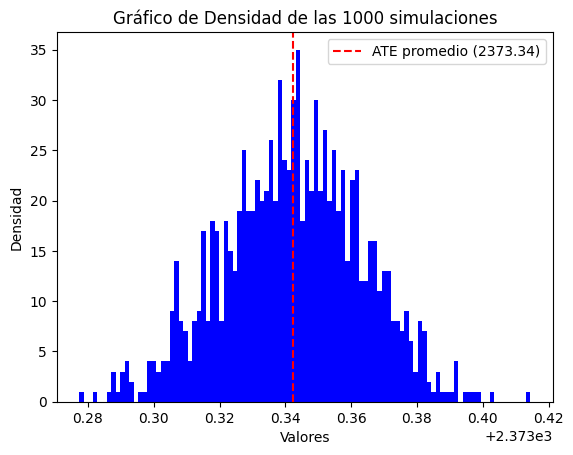

In [45]:
plt.hist(ate_resultados_b, bins=100, color='b')
plt.xlabel('Valores')
plt.ylabel('Densidad')
plt.title('Gráfico de Densidad de las 1000 simulaciones')

# Marcar el valor promedio con una línea vertical roja
plt.axvline(x=ate_promedio_b, color='red', linestyle='--', label=f'ATE promedio ({ate_promedio_b:.2f})')

# Mostrar una leyenda con las etiquetas
plt.legend()

plt.show()

In [23]:
ate_resultados

[2366.540156889205,
 2347.548919349172,
 2324.4028910635107,
 2358.5636118866296,
 2344.697893906192,
 2347.4712051230836,
 2355.5650626715724,
 2349.41034303817,
 2355.3336306400606,
 2339.858658997956,
 2359.333292328821,
 2362.407275309245,
 2350.348397202998,
 2356.791965804601,
 2375.07936008068,
 2356.45056752064,
 2366.8097851932007,
 2349.198110144759,
 2351.683950292627,
 2337.660565044658,
 2365.2906419119954,
 2350.3368510337204,
 2352.408031125481,
 2347.589772801165,
 2346.6457789380274,
 2363.982733529014,
 2349.2212143895194,
 2367.121264273075,
 2360.48548404111,
 2358.450786807727,
 2348.0183110669896,
 2342.277991153661,
 2350.1397169697975,
 2342.39034503323,
 2342.8406173044477,
 2345.615485716483,
 2357.045058553098,
 2352.1593390246126,
 2338.2960596747253,
 2348.681992803233,
 2350.8566214581842,
 2326.9943871254854,
 2355.7783026951174,
 2349.076638642766,
 2363.1045206146064,
 2370.220029372311,
 2355.12128759586,
 2363.3880422575985,
 2346.183999150293,
 2350.

b) Efecto tratamiento homog´eneo y regresi´on con t´erminos cuadr´aticos e interacci´on
y = β0 + β1 tratamiento + β2 Edadc + β3 Edad2
c + β4 Experienciac
+ β5 Experiencia2
c + β6 EdadxExper + ε

In [ ]:
n = 5000
seed = 263

# Elegimos la semilla 
np.random.seed(seed)

# Generamos los datos
data = pd.DataFrame()

edad_valores = np.concatenate([np.random.normal(20, 2.5, 2500), np.random.normal(25, 3, 2500)])
data['edad'] = edad_valores
exper_valores = np.concatenate([np.random.normal(1.76, 0.5, 2500), np.random.normal(2.3, 0.75, 2500)])
data['exper'] = exper_valores

# Centramos con respecto a la media
data['edad_c'] = data['edad'] - data['edad'].mean()
data['exper_c'] = data['exper'] - data['exper'].mean()

data['edad_c2'] = data['edad_c'] * data['edad_c']
data['exper_c2'] = data['exper_c'] * data['exper_c']

data['edadexper'] = data['edad_c'] * data['exper_c']

# Más variables
data['epsilon'] = np.random.normal(0, 0.5, n)
data['trat'] = 1
data.loc[2500:5000, 'trat'] = 0